# Baseline: Standard + CLS

Model Architecture #1 from the paper [Matching the Blanks: Distributional Similarity for Relation Learning](https://arxiv.org/abs/1906.03158) (Soares et al, 2019).

The model takes the standard input and uses the embedding from the `[CLS]` token as output. The model does not have any access to explicit identification of the entity spans $s_{1}$ and $s_{2}$. This is useful as a reference point, since the belief is that BERT (and other transformers) have the ability to identify entities in the text, but with this configuration it is not possible to know which two entities are in focus if there are multiple entity pairs.

## Environment Setup

In [1]:
!pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Imports

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import re
import shutil
import torch

from datasets import load_dataset, ClassLabel
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.optim import AdamW

from sklearn.metrics import (
    ConfusionMatrixDisplay, confusion_matrix, 
    classification_report, accuracy_score
)
from transformers import (
    AutoConfig, AutoTokenizer, AutoModelForSequenceClassification,
    DataCollatorWithPadding, get_scheduler
)
from transformers.modeling_outputs import SequenceClassifierOutput

%matplotlib inline

## Constants

In [3]:
GS_DATA_DIR = "/content/drive/MyDrive/neural-re-data"
DATA_DIR = "./data"

# BASE_MODEL_NAME = "bert-base-cased"
# BASE_MODEL_NAME = "xlm-roberta-base"
BASE_MODEL_NAME = "xlnet-base-cased"

MODEL_DIR = os.path.join(GS_DATA_DIR, "{:s}-scierc-std-cls".format(BASE_MODEL_NAME.split("-")[0]))

MAX_LENGTH = 400

BATCH_SIZE = 16

LEARNING_RATE = 5e-5
WEIGHT_DECAY = 1e-2

NUM_EPOCHS = 5

In [4]:
def set_random_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

set_random_seed(42)

## Data Processing

In [5]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!ls -l /content/drive/MyDrive/neural-re-data

total 6978
drwx------ 7 root root    4096 Jun 17 03:13 bert-scierc-std-cls
drwx------ 2 root root    4096 Jun  3 15:45 raw_data
-rw------- 1 root root 1417457 Jun  3 19:15 test.jsonl
-rw------- 1 root root 5140318 Jun  3 19:15 train.jsonl
-rw------- 1 root root  574016 Jun  3 19:15 val.jsonl
drwx------ 7 root root    4096 Jun 17 03:43 xlm-scierc-std-cls


In [7]:
with open(os.path.join(GS_DATA_DIR, "train.jsonl"), "r") as fin:
  for line in fin:
    rec = json.loads(line.strip())
    break

print(json.dumps(rec, indent=2))

{
  "text": " \n A method for  error correction  of  ill-formed input  is described that acquires  dialogue patterns  in typical usage and uses these  patterns  to predict new inputs.  Error correction  is done by strongly biasing  parsing  toward expected  meanings  unless clear evidence from the input shows the current  sentence  is not expected. A  dialogue acquisition and tracking algorithm  is presented along with a description of its  implementation  in a  voice interactive system  . A series of tests are described that show the power of the  error correction methodology  when  stereotypic dialogue  occurs. ",
  "h": {
    "type": "Generic",
    "start": 137,
    "end": 145,
    "span": "patterns"
  },
  "t": {
    "type": "OtherScientificTerm",
    "start": 85,
    "end": 102,
    "span": "dialogue patterns"
  },
  "r": "COREF"
}


In [8]:
def preprocess_text(text):
  text = text.replace("\n", " ")
  text = re.sub(r"\s+", " ", text)
  text = text.strip()
  return text

preprocess_text(rec["text"])

'A method for error correction of ill-formed input is described that acquires dialogue patterns in typical usage and uses these patterns to predict new inputs. Error correction is done by strongly biasing parsing toward expected meanings unless clear evidence from the input shows the current sentence is not expected. A dialogue acquisition and tracking algorithm is presented along with a description of its implementation in a voice interactive system . A series of tests are described that show the power of the error correction methodology when stereotypic dialogue occurs.'

In [9]:
def reformat_json(infile, outfile):
  num_recs = 0
  fout = open(outfile, "w")
  with open(infile, "r") as fin:
    for line in fin:
      rec = json.loads(line.strip())
      text = preprocess_text(rec["text"])
      text_a = " ".join(["[CLS]", text, "[SEP]"])
      label = rec["r"]
      output_rec = { "text": text_a, "label_s": label }
      fout.write(json.dumps(output_rec) + "\n")
      num_recs += 1
  print("reformatting {:s} -> {:s} ({:d} records)".format(infile, outfile, num_recs))


os.makedirs(DATA_DIR, exist_ok=True)

splits = ["train", "test", "val"]
for split in splits:
  reformat_json(os.path.join(GS_DATA_DIR, "{:s}.jsonl".format(split)),
                os.path.join(DATA_DIR, "{:s}.json".format(split)))

reformatting /content/drive/MyDrive/neural-re-data/train.jsonl -> ./data/train.json (4603 records)
reformatting /content/drive/MyDrive/neural-re-data/test.jsonl -> ./data/test.json (1279 records)
reformatting /content/drive/MyDrive/neural-re-data/val.jsonl -> ./data/val.json (512 records)


## Raw Dataset

In [10]:
data_files = {split: os.path.join(DATA_DIR, "{:s}.json".format(split)) for split in splits}
raw_dataset = load_dataset("json", data_files=data_files)
raw_dataset

Using custom data configuration default-9a215d6087a43881


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-9a215d6087a43881/0.0.0/da492aad5680612e4028e7f6ddc04b1dfcec4b64db470ed7cc5f2bb265b9b6b5. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label_s'],
        num_rows: 4603
    })
    test: Dataset({
        features: ['text', 'label_s'],
        num_rows: 1279
    })
    val: Dataset({
        features: ['text', 'label_s'],
        num_rows: 512
    })
})

## Label Mappings

In [11]:
relations = sorted([
  "USED-FOR", "COREF", "CONJUNCTION", "HYPONYM-OF", 
  "EVALUATE-FOR", "PART-OF", "FEATURE-OF", "COMPARE"
])
rel_tags = ClassLabel(names=relations)
label2id = {name: rel_tags.str2int(name) for name in relations}
id2label = {id: rel_tags.int2str(id) for id in range(len(relations))}

# label2id, id2label

## Encoded Dataset

In [12]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME)
inputs = tokenizer(preprocess_text(rec["text"]))

# inputs

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

In [13]:
def encode_data(examples):
  tokenized_inputs = tokenizer(examples["text"], 
                               padding=True, truncation=True,
                               max_length=MAX_LENGTH)
  tokenized_inputs["label"] = [label2id[label] for label in examples["label_s"]]
  return tokenized_inputs


# encoded = encode_data(raw_dataset["train"][0:5])
# encoded.keys()

In [14]:
enc_dataset = raw_dataset.map(encode_data, batched=True, remove_columns=["text", "label_s"])
enc_dataset

Parameter 'function'=<function encode_data at 0x7f8114235440> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'label'],
        num_rows: 4603
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'label'],
        num_rows: 1279
    })
    val: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'label'],
        num_rows: 512
    })
})

## DataLoader

In [15]:
collate_fn = DataCollatorWithPadding(tokenizer, padding="longest", return_tensors="pt")

train_dl = DataLoader(enc_dataset["train"], 
                      shuffle=True, 
                      # sampler=SubsetRandomSampler(np.random.randint(0, enc_dataset["train"].num_rows, 1000).tolist()),
                      batch_size=BATCH_SIZE, 
                      collate_fn=collate_fn)
valid_dl = DataLoader(enc_dataset["val"], 
                      shuffle=False, 
                      # sampler=SubsetRandomSampler(np.random.randint(0, enc_dataset["val"].num_rows, 200).tolist()),
                      batch_size=BATCH_SIZE, 
                      collate_fn=collate_fn)
test_dl = DataLoader(enc_dataset["test"], 
                     shuffle=False,
                    #  sampler=SubsetRandomSampler(np.random.randint(0, enc_dataset["test"].num_rows, 100).tolist()),
                     batch_size=BATCH_SIZE, 
                     collate_fn=collate_fn)


## Model

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
config = AutoConfig.from_pretrained(BASE_MODEL_NAME, num_labels=len(relations))
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL_NAME, config=config)
model = model.to(device)

# model

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

## Training

In [18]:
optimizer = AdamW(model.parameters(),
                  lr=LEARNING_RATE,
                  weight_decay=WEIGHT_DECAY)

num_training_steps = NUM_EPOCHS * len(train_dl)
lr_scheduler = get_scheduler("linear",
                             optimizer=optimizer,
                             num_warmup_steps=0,
                             num_training_steps=num_training_steps)

In [19]:
def compute_accuracy(labels, logits):
  preds_cpu = torch.argmax(logits, dim=-1).cpu().numpy()
  labels_cpu = labels.cpu().numpy()
  return accuracy_score(labels_cpu, preds_cpu)


def do_train(model, train_dl):
  train_loss = 0
  model.train()
  for bid, batch in enumerate(train_dl):
    batch = {k: v.to(device) for k, v in batch.items()}
    outputs = model(**batch)
    loss = outputs.loss
    train_loss += loss.detach().cpu().numpy()
    loss.backward()

    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()

  return train_loss


def do_eval(model, eval_dl):
  model.eval()
  eval_loss, eval_score, num_batches = 0, 0, 0
  for bid, batch in enumerate(eval_dl):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
      outputs = model(**batch)

    loss = outputs.loss

    eval_loss += loss.detach().cpu().numpy()
    eval_score += compute_accuracy(batch["labels"], outputs.logits)
    num_batches += 1

  eval_score /= num_batches
  return eval_loss, eval_score


def save_checkpoint(model, model_dir, epoch):
  model.save_pretrained(os.path.join(MODEL_DIR, "ckpt-{:d}".format(epoch)))


def save_training_history(history, model_dir, epoch):
  fhist = open(os.path.join(MODEL_DIR, "history.tsv"), "w")
  for epoch, train_loss, eval_loss, eval_score in history:
    fhist.write("{:d}\t{:.5f}\t{:.5f}\t{:.5f}\n".format(
        epoch, train_loss, eval_loss, eval_score))
  fhist.close()

In [20]:
if os.path.exists(MODEL_DIR):
  shutil.rmtree(MODEL_DIR)
  os.makedirs(MODEL_DIR)

history = []

for epoch in range(NUM_EPOCHS):
  train_loss = do_train(model, train_dl)
  eval_loss, eval_score = do_eval(model, valid_dl)
  history.append((epoch + 1, train_loss, eval_loss, eval_score))
  print("EPOCH {:d}, train loss: {:.3f}, val loss: {:.3f}, val-acc: {:.5f}".format(
      epoch + 1, train_loss, eval_loss, eval_score))
  save_checkpoint(model, MODEL_DIR, epoch + 1)
  save_training_history(history, MODEL_DIR, epoch + 1)

EPOCH 1, train loss: 497.493, val loss: 54.752, val-acc: 0.38086
EPOCH 2, train loss: 489.112, val loss: 53.747, val-acc: 0.38086
EPOCH 3, train loss: 470.272, val loss: 53.562, val-acc: 0.37500
EPOCH 4, train loss: 455.687, val loss: 54.598, val-acc: 0.33594
EPOCH 5, train loss: 436.639, val loss: 55.438, val-acc: 0.35938


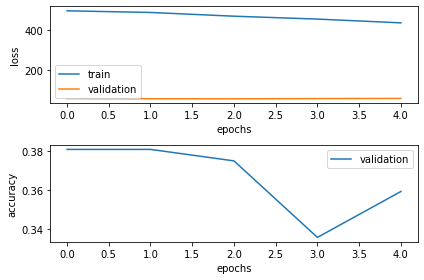

In [21]:
plt.subplot(2, 1, 1)
plt.plot([train_loss for _, train_loss, _, _ in history], label="train")
plt.plot([eval_loss for _, _, eval_loss, _ in history], label="validation")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc="best")

plt.subplot(2, 1, 2)
plt.plot([eval_score for _, _, _, eval_score in history], label="validation")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(loc="best")

plt.tight_layout()
_ = plt.show()

## Evaluation

In [22]:
ytrue, ypred = [], []
for batch in test_dl:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
      outputs = model(**batch)
      predictions = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
      labels = batch["labels"].cpu().numpy()
      ytrue.extend(labels)
      ypred.extend(predictions)

print("test accuracy: {:.3f}".format(accuracy_score(ytrue, ypred)))

test accuracy: 0.351


In [23]:
print(classification_report(ytrue, ypred, target_names=relations))

              precision    recall  f1-score   support

     COMPARE       0.00      0.00      0.00        47
 CONJUNCTION       0.18      0.06      0.09       117
       COREF       0.31      0.20      0.24       335
EVALUATE-FOR       0.11      0.10      0.10        91
  FEATURE-OF       0.00      0.00      0.00        53
  HYPONYM-OF       0.17      0.15      0.16        95
     PART-OF       0.11      0.02      0.03        54
    USED-FOR       0.41      0.72      0.52       487

    accuracy                           0.35      1279
   macro avg       0.16      0.16      0.14      1279
weighted avg       0.28      0.35      0.29      1279



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


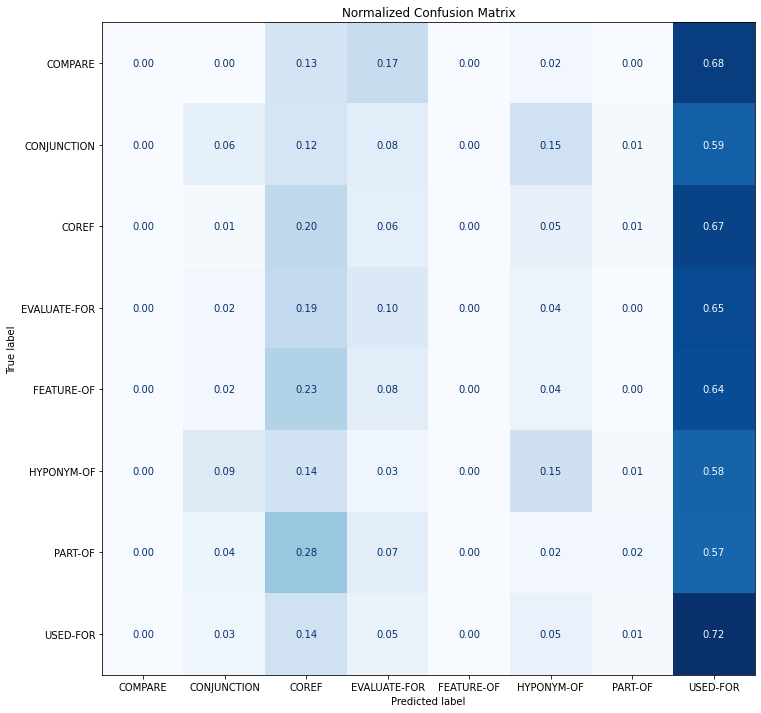

In [24]:
def plot_confusion_matrix(ytrue, ypreds, labels):
  cm = confusion_matrix(ytrue, ypreds, normalize="true")
  fig, ax = plt.subplots(figsize=(12, 12))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format="0.2f", ax=ax, colorbar=False)
  plt.title("Normalized Confusion Matrix")
  _ = plt.show()


plot_confusion_matrix(ytrue, ypred, relations)